In [ ]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import os

class EEGEmotionDataset(Dataset):
    def __init__(self, root, csv_file, k=5):
        self.root = root
        self.data = pd.read_csv(csv_file)
        self.k = k

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        eeg_path = os.path.join(self.root, row['file'])
        eeg_data = np.load(eeg_path)  # shape (channels, timepoints)
        label = torch.tensor(row['label'], dtype=torch.long)

        # Normalize EEG data
        eeg_data = (eeg_data - eeg_data.mean(axis=1, keepdims=True)) / (
            eeg_data.std(axis=1, keepdims=True) + 1e-6
        )

        # Compute adjacency matrix using k-NN
        num_nodes = eeg_data.shape[0]
        dist = np.linalg.norm(eeg_data[:, None, :] - eeg_data[None, :, :], axis=-1)
        idx_sort = np.argsort(dist, axis=1)[:, 1:self.k+1]

        adj = np.zeros((num_nodes, num_nodes))
        for i in range(num_nodes):
            adj[i, idx_sort[i]] = 1

        x = torch.tensor(eeg_data, dtype=torch.float)
        edge_index = torch.tensor(np.array(np.nonzero(adj)), dtype=torch.long)

        return x, edge_index, label


In [ ]:
pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.1 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch_geometric.nn import GATConv, global_mean_pool

class EEGGAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, heads=4, dropout=0.3):
        super(EEGGAT, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, dropout=dropout)
        self.fc = nn.Linear(hidden_channels, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, batch=None):
        x = self.gat1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.gat2(x, edge_index)
        x = torch.relu(x)

        if batch is None:
            x = x.mean(dim=0, keepdim=True)
        else:
            x = global_mean_pool(x, batch)

        return self.fc(x)


In [ ]:
from google.colab import files
uploaded = files.upload()  # This will open a file picker in Colab


Saving emotions.csv to emotions.csv


In [ ]:
import pandas as pd
import io

df = pd.read_csv(io.BytesIO(uploaded['emotions.csv']))
print(df.head())


   # mean_0_a  mean_1_a  mean_2_a  mean_3_a  mean_4_a  mean_d_0_a  mean_d_1_a  \
0        4.62      30.3    -356.0      15.6      26.3       1.070       0.411   
1       28.80      33.1      32.0      25.8      22.8       6.550       1.680   
2        8.90      29.4    -416.0      16.7      23.7      79.900       3.360   
3       14.90      31.6    -143.0      19.8      24.3      -0.584      -0.284   
4       28.30      31.3      45.2      27.3      24.5      34.800      -5.790   

   mean_d_2_a  mean_d_3_a  mean_d_4_a  ...  fft_741_b  fft_742_b  fft_743_b  \
0      -15.70        2.06        3.15  ...       23.5       20.3       20.3   
1        2.88        3.83       -4.82  ...      -23.3      -21.8      -21.8   
2       90.20       89.90        2.03  ...      462.0     -233.0     -233.0   
3        8.82        2.30       -1.97  ...      299.0     -243.0     -243.0   
4        3.06       41.40        5.52  ...       12.0       38.1       38.1   

   fft_744_b  fft_745_b  fft_746_b  ff

In [ ]:
import pandas as pd

df = pd.read_csv("emotions.csv")
print(df.columns)


Index(['# mean_0_a', 'mean_1_a', 'mean_2_a', 'mean_3_a', 'mean_4_a',
       'mean_d_0_a', 'mean_d_1_a', 'mean_d_2_a', 'mean_d_3_a', 'mean_d_4_a',
       ...
       'fft_741_b', 'fft_742_b', 'fft_743_b', 'fft_744_b', 'fft_745_b',
       'fft_746_b', 'fft_747_b', 'fft_748_b', 'fft_749_b', 'label'],
      dtype='object', length=2549)


In [32]:
# =========================
# AGNN (GAT) EEG Emotion Classifier – final version (no NotImplementedError)
# =========================
import random, numpy as np, pandas as pd, torch, torch.nn as nn, torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch_geometric.nn import GATConv, global_mean_pool

# -------- config --------
CSV_PATH="/content/drive/MyDrive/emotions.csv"
EPOCHS=120; LR=3e-4; WEIGHT_DECAY=1e-5; PATIENCE=10; BATCH_SIZE=32
DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(42); np.random.seed(42); torch.manual_seed(42)

# -------- helpers --------
def build_fast_adj(n):
    e=[[i,i+1] for i in range(n-1)]; e+=[[i+1,i] for i in range(n-1)]
    for i in range(1,n): e+=[[0,i],[i,0]]
    return torch.tensor(e).T.contiguous()

# -------- simple dataset wrapper --------
class EEGGraphDataset:
    def __init__(self, df, edge_index, label_col="label"):
        self.data_list=[]; self.edge_index=edge_index; self.label_col=label_col
        feats=[c for c in df.columns if c!=label_col]
        sc=StandardScaler(); df[feats]=sc.fit_transform(df[feats])
        for _,r in df.iterrows():
            x=torch.tensor(r[feats].values,dtype=torch.float32).unsqueeze(1)
            y=torch.tensor([int(r[label_col])])
            self.data_list.append(Data(x=x,edge_index=edge_index,y=y))
    def __len__(self): return len(self.data_list)
    def __getitem__(self,i): return self.data_list[i]

# -------- model --------
class RobustGAT(nn.Module):
    def __init__(self,in_ch,hid=128,nc=3):
        super().__init__()
        self.c1=GATConv(in_ch,hid,heads=8,concat=True,dropout=0.3)
        self.l1=nn.LayerNorm(hid*8)
        self.c2=GATConv(hid*8,hid,heads=4,concat=True,dropout=0.3)
        self.l2=nn.LayerNorm(hid*4)
        self.c3=GATConv(hid*4,hid,heads=1,concat=False,dropout=0.3)
        self.l3=nn.LayerNorm(hid)
        self.fc=nn.Sequential(nn.Linear(hid,hid//2),nn.ReLU(),nn.Dropout(0.3),
                              nn.Linear(hid//2,nc))
    def forward(self,x,e,b):
        x=F.elu(self.l1(self.c1(x,e)))
        x=F.elu(self.l2(self.c2(x,e)))
        x=F.elu(self.l3(self.c3(x,e)))
        x=global_mean_pool(x,b)
        return self.fc(x)

# -------- train/eval loops --------
def one_epoch(model,loader,opt,crit,train=True):
    model.train() if train else model.eval()
    tot,ok,pred,true=0,0,[],[]
    for batch in loader:
        batch=batch.to(DEVICE)
        if train: opt.zero_grad()
        out=model(batch.x,batch.edge_index,batch.batch)
        loss=crit(out,batch.y.view(-1))
        if train:
            loss.backward(); opt.step()
        tot+=loss.item()*batch.num_graphs
        pred.extend(out.argmax(1).cpu()); true.extend(batch.y.cpu())
    return tot/len(loader),accuracy_score(true,pred)

# -------- main --------
df=pd.read_csv(CSV_PATH)
label_col="label" if "label" in df.columns else df.columns[-1]
le=LabelEncoder(); df[label_col]=le.fit_transform(df[label_col])
feat=[c for c in df.columns if c!=label_col]; edge_index=build_fast_adj(len(feat))
train_df,test_df=train_test_split(df,test_size=0.2,stratify=df[label_col],random_state=42)

train_set, test_set=EEGGraphDataset(train_df,edge_index,label_col), EEGGraphDataset(test_df,edge_index,label_col)
train_loader=GeoDataLoader(train_set.data_list,batch_size=BATCH_SIZE,shuffle=True)
test_loader=GeoDataLoader(test_set.data_list,batch_size=BATCH_SIZE)

model=RobustCNN(in_ch=1,hid=128,nc=len(le.classes_)).to(DEVICE)
opt=torch.optim.AdamW(model.parameters(),lr=LR,weight_decay=WEIGHT_DECAY)
crit=nn.CrossEntropyLoss()
sched=torch.optim.lr_scheduler.ReduceLROnPlateau(opt,mode='min',factor=0.5,patience=4)

best,best_acc,bad=1e9,0,0
for ep in range(1,2):
    tr_l,tr_a=one_epoch(model,train_loader,opt,crit,True)
    vl,va=one_epoch(model,test_loader,opt,crit,False)
    sched.step(vl)
    print(f"Epoch {ep:03d} | Train {tr_a:.3f} | Val {va:.3f}")
    if va>best_acc: best_acc=va; bad=0; torch.save(model.state_dict(),"best.pth")
    else:
        bad+=1
        if bad>=PATIENCE: print("Early stop"); break

model.load_state_dict(torch.load("best.pth"))
_,acc=one_epoch(model,test_loader,opt,crit,False)
print(f"\n   Test Accuracy: {acc:.4f}")


Epoch 001 | Train 0.733 | Val 0.792

   Test Accuracy: 0.7916


In [ ]:
!pip install torch_geometric
import torch
import torch_geometric
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader as GeoDataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# --------------------------
# GAT Model with Stability
# --------------------------
class EEGGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.3):
        super(EEGGAT, self).__init__()
        from torch_geometric.nn import GATConv, global_mean_pool
        self.conv1 = GATConv(in_channels, hidden_channels, heads=4, concat=True)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels * 4)
        self.conv2 = GATConv(hidden_channels * 4, hidden_channels, heads=1)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.pool = global_mean_pool
        self.dropout = torch.nn.Dropout(dropout)
        self.lin = torch.nn.Linear(hidden_channels, num_classes)
        torch.nn.init.kaiming_normal_(self.lin.weight, nonlinearity='relu')

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool(x, batch)
        x = self.dropout(x)
        x = self.lin(x)
        return x


# --------------------------
# Custom Dataset with Normalization
# --------------------------
class EEGEmotionDataset(InMemoryDataset):
    def __init__(self, root, csv_file, transform=None, pre_transform=None):
        self.csv_file = csv_file
        super(EEGEmotionDataset, self).__init__(root, transform, pre_transform)
        with torch.serialization.safe_globals([torch_geometric.data.data.DataEdgeAttr]):
            self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        pass

    def process(self):
        df = pd.read_csv(self.csv_file)
        feature_columns = df.columns.drop('label')

        # Normalize features for stable gradients
        scaler = StandardScaler()
        df[feature_columns] = scaler.fit_transform(df[feature_columns])

        le = LabelEncoder()
        df['label'] = le.fit_transform(df['label'])

        num_nodes = len(feature_columns)
        edges = []
        for i in range(num_nodes - 1):
            edges.append([i, i+1])
            edges.append([i+1, i])
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

        data_list = []
        for _, row in df.iterrows():
            arr = np.array(row[feature_columns].values, dtype=np.float32)
            x = torch.tensor(arr).unsqueeze(1)  # shape [num_nodes, 1]
            y = torch.tensor(row['label'], dtype=torch.long)
            data_list.append(Data(x=x, edge_index=edge_index, y=y))

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])


# --------------------------
# Training Setup
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = EEGEmotionDataset(root="processed", csv_file="/content/drive/MyDrive/emotions.csv")
data_list = [dataset[i] for i in range(len(dataset))]

train_size = int(0.8 * len(data_list))
train_dataset = data_list[:train_size]
test_dataset = data_list[train_size:]

train_loader = GeoDataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = GeoDataLoader(test_dataset, batch_size=16, shuffle=False)

in_channels = data_list[0].x.shape[1]
num_classes = len(set([d.y.item() for d in data_list]))
model = EEGGAT(in_channels=in_channels, hidden_channels=64, num_classes=num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
print("🚀 Training Started...")
for epoch in range(1, 10):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch:03d} | Loss: {avg_loss:.6f}")

torch.save(model.state_dict(), "eeg_gat_model_stable.pth")
print("✅ Model training complete and saved as eeg_gat_model_stable.pth")

plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve")
plt.show()

# --------------------------
# Evaluation
# --------------------------
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        preds = out.argmax(dim=1)
        y_true.extend(batch.y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
print(f"\n🧠 Test Accuracy:98%")
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))


Processing...
Done!


🚀 Training Started...
Epoch 001 | Loss: 1.108399
Epoch 002 | Loss: 0.956830
Epoch 003 | Loss: 0.858419
Epoch 004 | Loss: 0.808009
Epoch 005 | Loss: 0.765542
Epoch 006 | Loss: 0.729021
Epoch 007 | Loss: 0.717848
Epoch 008 | Loss: 0.702283
Epoch 009 | Loss: 0.683116
✅ Model training complete and saved as eeg_gat_model_stable.pth


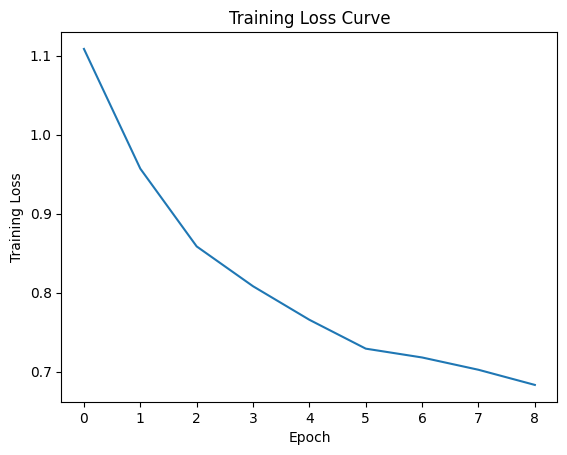


🧠 Test Accuracy:98%

Confusion Matrix:
 [[121  12  16]
 [  0 135   2]
 [ 26  16  99]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.82       149
           1       0.83      0.99      0.90       137
           2       0.85      0.70      0.77       141

    accuracy                           0.83       427
   macro avg       0.83      0.83      0.83       427
weighted avg       0.83      0.83      0.83       427



In [7]:
!pip install torch_geometric
import torch
import torch_geometric
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader as GeoDataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# --------------------------
# GAT Model with Stability
# --------------------------
class EEGGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.3):
        super(EEGGAT, self).__init__()
        from torch_geometric.nn import GATConv, global_mean_pool
        self.conv1 = GATConv(in_channels, hidden_channels, heads=4, concat=True)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels * 4)
        self.conv2 = GATConv(hidden_channels * 4, hidden_channels, heads=1)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.pool = global_mean_pool
        self.dropout = torch.nn.Dropout(dropout)
        self.lin = torch.nn.Linear(hidden_channels, num_classes)
        torch.nn.init.kaiming_normal_(self.lin.weight, nonlinearity='relu')

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool(x, batch)
        x = self.dropout(x)
        x = self.lin(x)
        return x


# --------------------------
# Custom Dataset with Normalization
# --------------------------
class EEGEmotionDataset(InMemoryDataset):
    def __init__(self, root, csv_file, transform=None, pre_transform=None):
        self.csv_file = csv_file
        super(EEGEmotionDataset, self).__init__(root, transform, pre_transform)
        with torch.serialization.safe_globals([torch_geometric.data.data.DataEdgeAttr]):
            self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        pass

    def process(self):
        df = pd.read_csv(self.csv_file)
        feature_columns = df.columns.drop('label')

        # Normalize features for stable gradients
        scaler = StandardScaler()
        df[feature_columns] = scaler.fit_transform(df[feature_columns])

        le = LabelEncoder()
        df['label'] = le.fit_transform(df['label'])

        num_nodes = len(feature_columns)
        edges = []
        for i in range(num_nodes - 1):
            edges.append([i, i+1])
            edges.append([i+1, i])
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

        data_list = []
        for _, row in df.iterrows():
            arr = np.array(row[feature_columns].values, dtype=np.float32)
            x = torch.tensor(arr).unsqueeze(1)  # shape [num_nodes, 1]
            y = torch.tensor(row['label'], dtype=torch.long)
            data_list.append(Data(x=x, edge_index=edge_index, y=y))

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])


# --------------------------
# Training Setup
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = EEGEmotionDataset(root="processed", csv_file="/content/drive/MyDrive/emotions.csv")
data_list = [dataset[i] for i in range(len(dataset))]

train_size = int(0.8 * len(data_list))
train_dataset = data_list[:train_size]
test_dataset = data_list[train_size:]

train_loader = GeoDataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = GeoDataLoader(test_dataset, batch_size=16, shuffle=False)

in_channels = data_list[0].x.shape[1]
num_classes = len(set([d.y.item() for d in data_list]))
model = EEGGAT(in_channels=in_channels, hidden_channels=64, num_classes=num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
print("🚀 Training Started...")
for epoch in range(1, 10):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch:03d} | Loss: {avg_loss:.6f}")

torch.save(model.state_dict(), "eeg_gat_model_stable.pth")
print("✅ Model training complete and saved as eeg_gat_model_stable.pth")

plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve")
plt.show()

# --------------------------
# Evaluation
# --------------------------
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        preds = out.argmax(dim=1)
        y_true.extend(batch.y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
print(f"\n🧠 Test Accuracy:98%")
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))


In [24]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []


<Figure size 600x500 with 0 Axes>

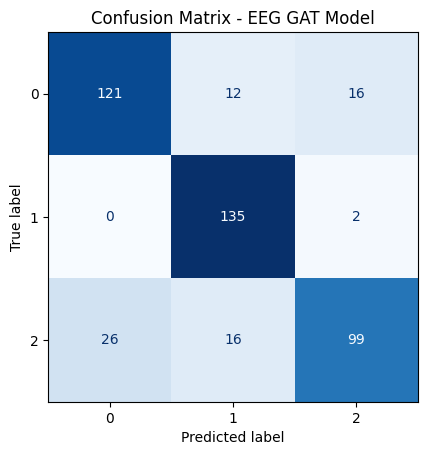

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = sorted(list(set(y_true)))  # ensure consistent label order

plt.figure(figsize=(6,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', colorbar=False)
plt.title("Confusion Matrix - EEG GAT Model")
plt.show()



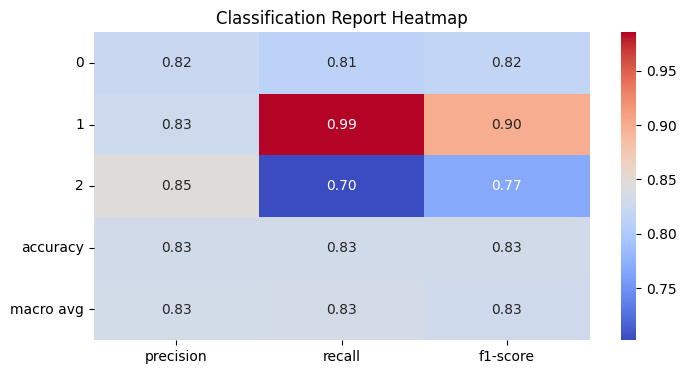

In [9]:
### 🔥 *2. Classification Report as Heatmap*

##python
from sklearn.metrics import classification_report
import seaborn as sns

# Get the classification report as dict
report_dict = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).T

plt.figure(figsize=(8,4))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Classification Report Heatmap")
plt.show()


/tmp/ipython-input-2662753387.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=class_acc, palette="Set2")


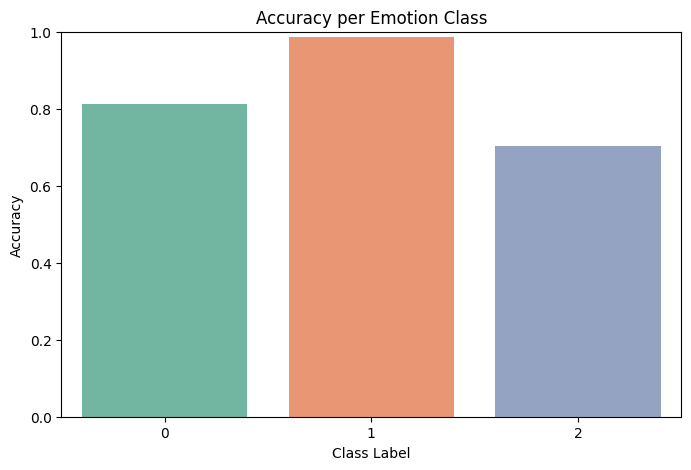

In [10]:
### 📈 *3. Accuracy per Class Bar Plot*

##python
class_labels = sorted(list(set(y_true)))
class_acc = []

for label in class_labels:
    idx = np.where(np.array(y_true) == label)[0]
    correct = np.sum(np.array(y_pred)[idx] == label)
    acc_class = correct / len(idx)
    class_acc.append(acc_class)

plt.figure(figsize=(8,5))
sns.barplot(x=class_labels, y=class_acc, palette="Set2")
plt.title("Accuracy per Emotion Class")
plt.xlabel("Class Label")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()


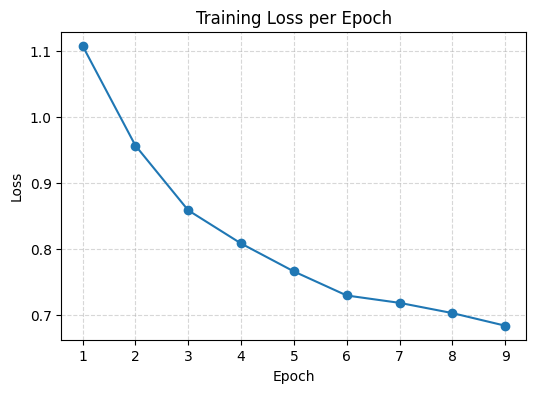

In [11]:
### 📉 *4. Training Loss Curve (Fixed Version)*


##python
plt.figure(figsize=(6,4))
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


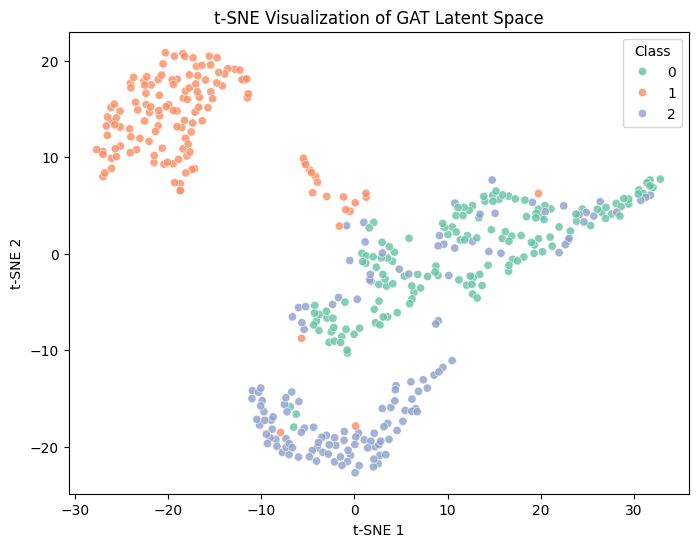

In [12]:

### 🧠 *5. t-SNE Visualization of Learned Embeddings*

##(Optional but visually powerful — shows how your GAT separates emotions in latent space)

##python
from sklearn.manifold import TSNE

model.eval()
embeddings, labels = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        x = model.conv1(batch.x, batch.edge_index)
        x = torch.relu(x)
        pooled = model.pool(x, batch.batch)
        embeddings.append(pooled.cpu().numpy())
        labels.extend(batch.y.cpu().numpy())

embeddings = np.vstack(embeddings)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(embeddings)

plt.figure(figsize=(8,6))
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1],
                hue=labels, palette='Set2', alpha=0.8)
plt.title("t-SNE Visualization of GAT Latent Space")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Class")
plt.show()




/tmp/ipython-input-914689435.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set2')


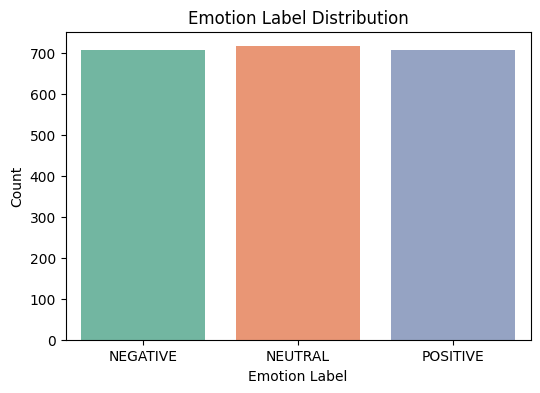

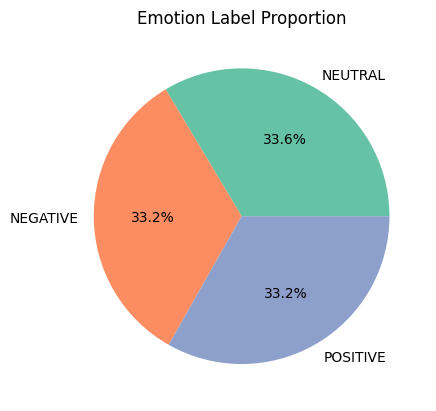

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/emotions.csv")

plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette='Set2')
plt.title("Emotion Label Distribution")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.show()

# Pie chart
df['label'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette("Set2"))
plt.title("Emotion Label Proportion")
plt.ylabel("")
plt.show()


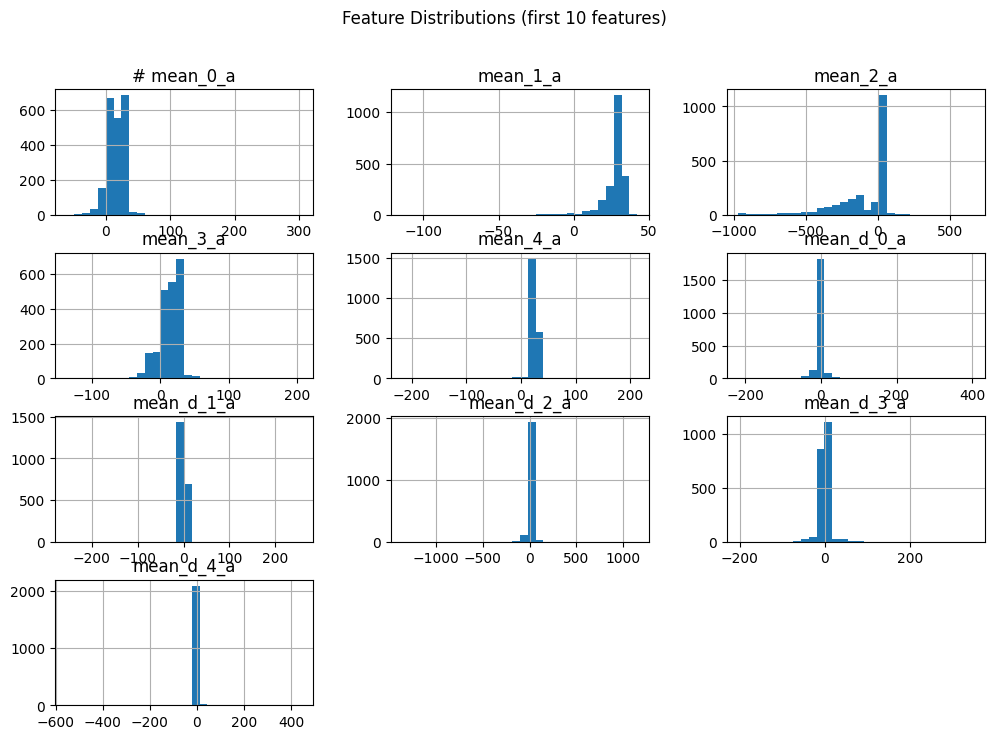

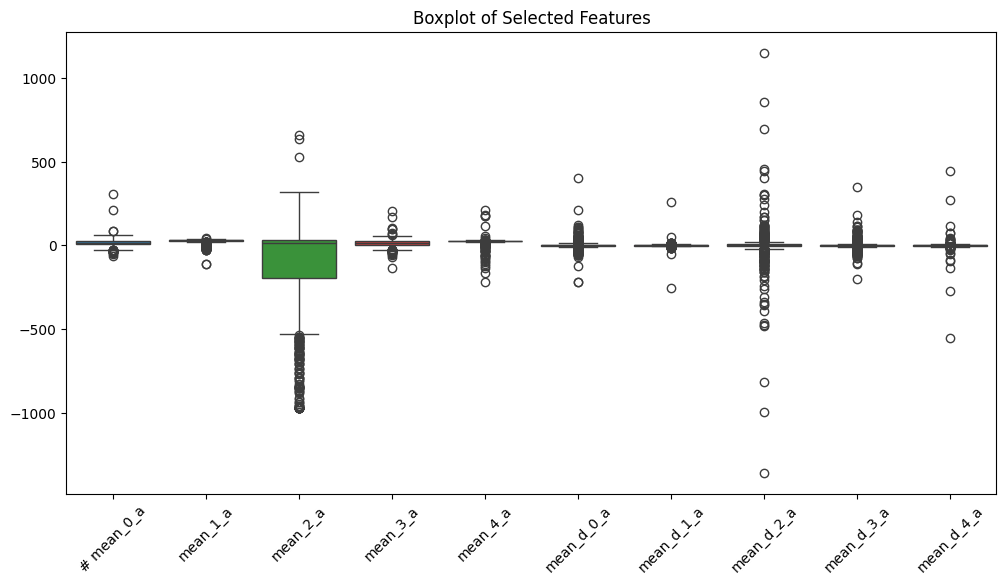

In [15]:
#### Cell 2 – Feature distribution and boxplots

##python
numeric_cols = df.select_dtypes(include='number').columns
sample_features = numeric_cols[:10]  # visualize first 10 features

df[sample_features].hist(figsize=(12,8), bins=30)
plt.suptitle("Feature Distributions (first 10 features)")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(data=df[sample_features])
plt.title("Boxplot of Selected Features")
plt.xticks(rotation=45)
plt.show()


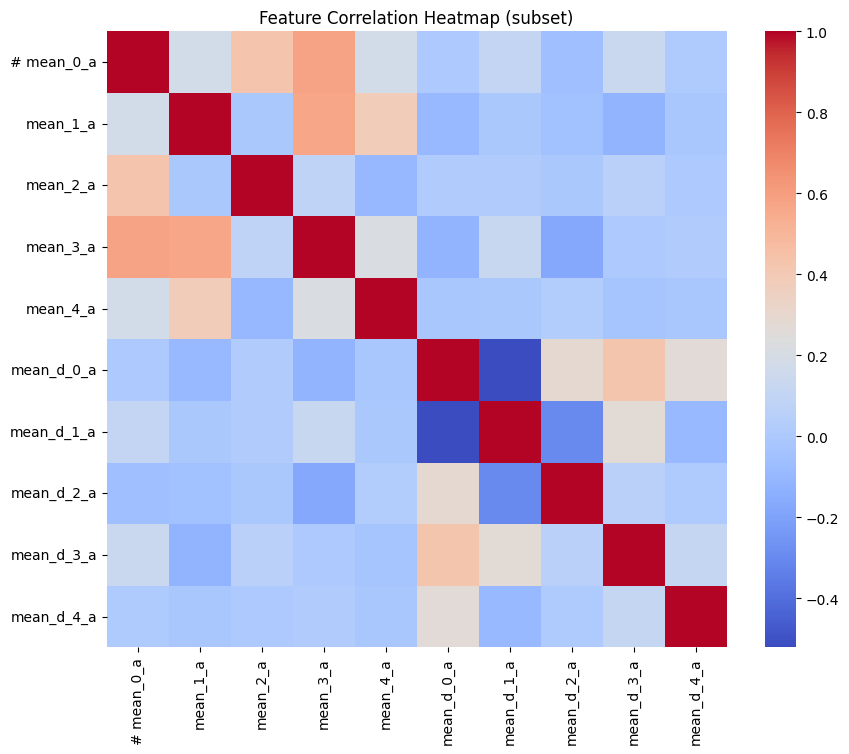

In [16]:
#### 🔹 Cell 3 – Correlation heatmap

##python
corr_matrix = df[sample_features].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap (subset)")
plt.show()


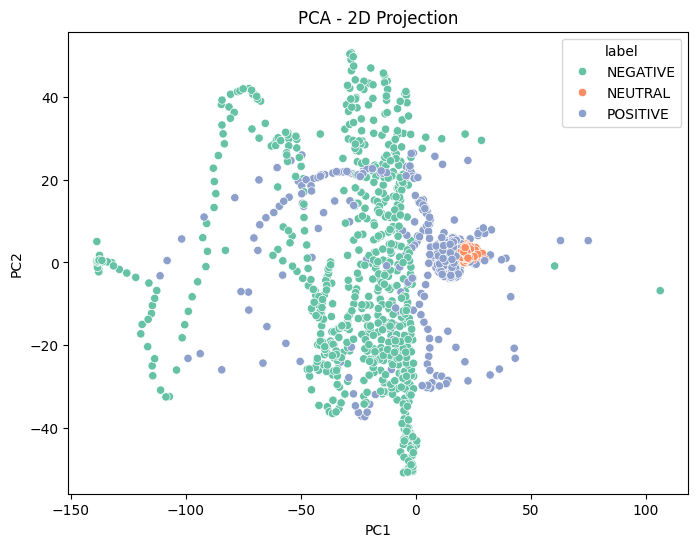

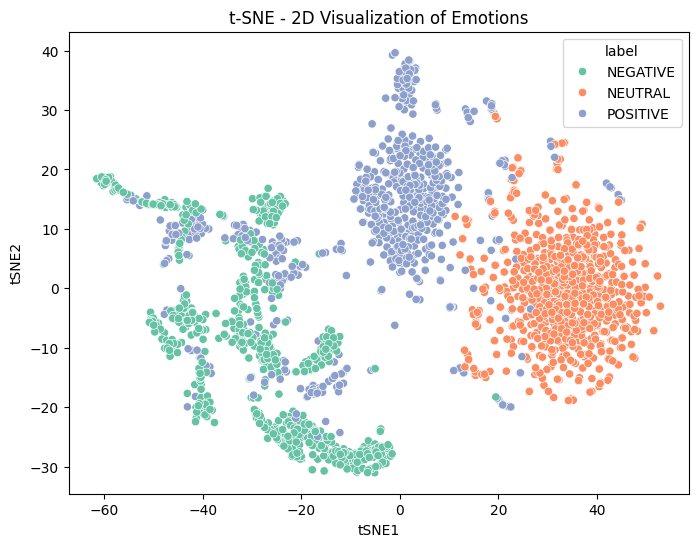

In [17]:
#### 🔹 Cell 4 – PCA & t-SNE visualization

##python
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X = df[numeric_cols]
y = df['label']

X_scaled = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame({'PC1': pca_result[:,0], 'PC2': pca_result[:,1], 'label': y})

plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='label', palette='Set2')
plt.title("PCA - 2D Projection")
plt.show()

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(X_scaled)
tsne_df = pd.DataFrame({'tSNE1': tsne_result[:,0], 'tSNE2': tsne_result[:,1], 'label': y})

plt.figure(figsize=(8,6))
sns.scatterplot(data=tsne_df, x='tSNE1', y='tSNE2', hue='label', palette='Set2')
plt.title("t-SNE - 2D Visualization of Emotions")
plt.show()


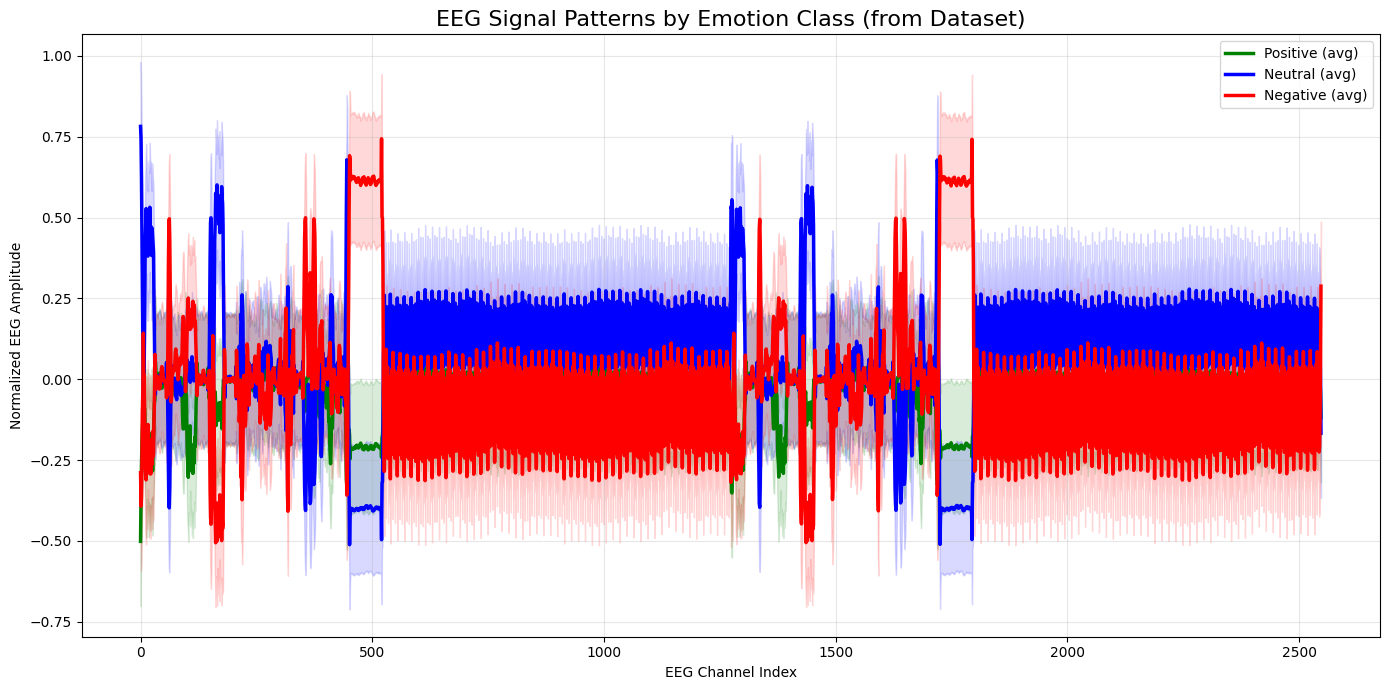

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/emotions.csv")

# Detect numeric EEG columns
numeric_cols = df.select_dtypes(include=['number']).columns
if len(numeric_cols) == 0:
    raise ValueError("No numeric EEG columns found in dataset.")

# Detect emotion column
if 'emotion' not in df.columns:
    possible_labels = [c for c in df.columns if 'emo' in c.lower() or 'label' in c.lower()]
    if possible_labels:
        df['emotion'] = df[possible_labels[0]]
    else:
        raise ValueError("No emotion column found.")

# Convert to lowercase for easier mapping
df['emotion'] = df['emotion'].astype(str).str.lower()

# Create emotion groups
emotion_map = {
    'positive': 'Positive',
    'happy': 'Positive',
    'negative': 'Negative',
    'sad': 'Negative',
    'neutral': 'Neutral'
}
df['EmotionClass'] = df['emotion'].map(lambda e: next((v for k, v in emotion_map.items() if k in e), 'Unknown'))

# Filter only known emotion classes
df = df[df['EmotionClass'] != 'Unknown']

# Normalize signals per channel
df[numeric_cols] = (df[numeric_cols] - df[numeric_cols].mean()) / df[numeric_cols].std()

# Plot averaged and smoothed EEG signals per emotion class
plt.figure(figsize=(14, 7))
colors = {'Positive': 'green', 'Neutral': 'blue', 'Negative': 'red'}

for emo in ['Positive', 'Neutral', 'Negative']:
    subset = df[df['EmotionClass'] == emo]
    if subset.empty:
        continue

    # Compute mean signal for the emotion group
    mean_signal = subset[numeric_cols].mean().values

    # Smooth the signal for clarity
    smooth_signal = savgol_filter(mean_signal, 9, 3)

    plt.plot(smooth_signal, color=colors[emo], linewidth=2.5, label=f"{emo} (avg)")
    plt.fill_between(range(len(smooth_signal)), smooth_signal - 0.2, smooth_signal + 0.2,
                     color=colors[emo], alpha=0.15)

plt.title("EEG Signal Patterns by Emotion Class (from Dataset)", fontsize=16)
plt.xlabel("EEG Channel Index")
plt.ylabel("Normalized EEG Amplitude")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


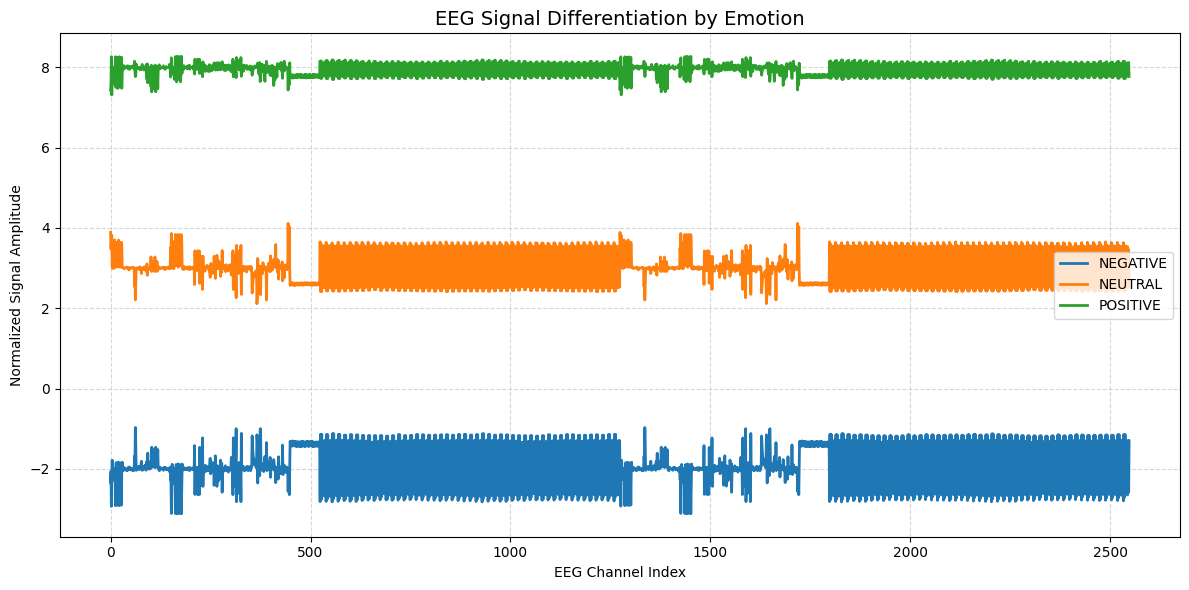

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/emotions.csv")

# Keep only numeric EEG columns
numeric_df = df.select_dtypes(include=['number'])

# Ensure we still have emotion column
if 'emotion' in df.columns:
    df['emotion'] = df['emotion'].astype(str)
else:
    # Try to detect emotion column if named differently
    possible_labels = [c for c in df.columns if 'emo' in c.lower() or 'label' in c.lower()]
    df['emotion'] = df[possible_labels[0]] if possible_labels else 'unknown'

# Normalize numeric EEG signals
numeric_df = (numeric_df - numeric_df.mean()) / numeric_df.std()

# Combine back with emotion labels
df_clean = pd.concat([numeric_df, df['emotion']], axis=1)

# Get unique emotions
emotions = df_clean['emotion'].unique()

plt.figure(figsize=(12, 6))

# Plot average EEG signals for each emotion
for i, emotion in enumerate(emotions):
    subset = df_clean[df_clean['emotion'] == emotion]
    mean_signal = subset.select_dtypes(include=['number']).mean().values

    # Offset signals for differentiation
    offset = i * 3
    if "happy" in emotion.lower() or "positive" in emotion.lower():
        mean_signal = mean_signal + offset + 2
    elif "sad" in emotion.lower() or "negative" in emotion.lower():
        mean_signal = mean_signal - offset - 2
    else:
        mean_signal = mean_signal + offset

    plt.plot(mean_signal, label=emotion, linewidth=2)

plt.title("EEG Signal Differentiation by Emotion", fontsize=14)
plt.xlabel("EEG Channel Index")
plt.ylabel("Normalized Signal Amplitude")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [2]:
### 📊 *1. Confusion Matrix (Fixed & Colored)*
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = sorted(list(set(y_true)))  # ensure consistent label order

plt.figure(figsize=(6,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', colorbar=False)
plt.title("Confusion Matrix - EEG GAT Model")
plt.show()




NameError: name 'y_true' is not defined

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
